### Load data

In [1]:
class dataset:
    def __init__(self, rooms,courses,students,constraints):
        self.rooms=rooms
        self.courses=courses
        self.students=students
        self.constraints=constraints

In [2]:
import pickle
with open('data_06.pickle', 'rb') as file:
    dataset = pickle.load(file)

In [3]:
from docplex.mp.model import Model
import time

solution_filename = 'sol_06_mp.py'
progress_filename = 'sol_06_mp.txt'

rooms = dataset.rooms
courses=dataset.courses
#courses = [course['config'][0] for course in dataset.courses]
i=1
for course in courses:
    course['id']=i
    i+=1
students = dataset.students
constraints = dataset.constraints

List of supporting tables:
* `classes`: 150 classes with details
* `classes_id`: ids from 1 to 150
* `rooms_id`: ids from 1 to 7
* `students_id`: ids from 1 to 19
* `student_subparts`: pairs of 1 student & 1 subpart that he/she must attend (the subpart is a list of classes_id)
* `student_classes`: pairs of 1 student & the list of all classes that he/she might attend (flattened from above subpart) -> 19 pairs

In [31]:
rooms_id = [r['id'] for r in rooms]
students_id = [s['id'] for s in students]

# class-time pairs
classes = {}
for course in courses:
    for subpart in course['subpart']:
        for c in subpart['class']:
            if c['room']!=[]:
                classes[c['id']]=c
            
classes_id =list(classes.keys())
#[i for i in range(1,len(classes)+1)]


# student-subpart pairs
student_subparts = []
for s in students_id:
    for i in students[s-1]['course']:
        for subpart in courses[i-1]['subpart']:
            student_subparts.append([s,[c['id'] for c in subpart['class']]]) 

# student-classes pairs
student_classes = []
for s in students_id:
    student_classes.append([s, []])
    class_list = student_classes[-1][1]
    for i in students[s-1]['course']:
        for subpart in courses[i-1]['subpart']:
            for c in subpart['class']:
                class_list.append(c['id'])

# pairs of classes with SameAttendee constraint
SA_pairs=[]
for ct in constraints:
    if ct['type']=='SameAttendees':
        for i1 in range(len(ct['class'])):
            for i2 in range(i1+1, len(ct['class'])):
                c1, c2 = ct['class'][i1], ct['class'][i2]
                SA_pairs.append((c1,c2))

### support functions:

In [5]:
def clash(time1, time2):
    clash_days = bool(sum([int(a) & int(b) for a,b in zip(time1['days'], time2['days'])]))
    clash_weeks = bool(sum([int(a) & int(b) for a,b in zip(time1['weeks'], time2['weeks'])]))
    clash_time1 = int(time1['start']) < int(time2['start']) + int(time2['length'])
    clash_time2 = int(time1['start']) + int(time1['length']) > int(time2['start'])
    return clash_days and clash_weeks and clash_time1 and clash_time2

# Modeling

### Decision Variables

In [32]:
m = Model('model1')

# x = 1 if the class c takes place at time t, 0 otherwise
x = m.binary_var_dict([(c,t) 
                       for c in classes_id 
                       for t in range(len(classes[c]['time']))], name= 'x')

# y = 1 if the class c takes place at room r, 0 otherwise
y = m.binary_var_dict([(c,r) 
                       for c in classes_id 
                       for r in range(len(classes[c]['room']))], name= 'y')

# z = 1 if the student s takes class c, 0 otherwise
z = m.binary_var_dict([(s,c) 
                       for s in students_id 
                       for c in student_classes[s-1][1]], name= 'z')

### Objective functions
(skip if only search for feasible solution)

### Constraints

In [35]:
# Every class must be assigned a time
m.add_constraints(m.sum(x[c,t] for t in range(len(classes[c]['time']))) == 1 
                  for c in classes_id)

# Every class must be assigned a room, where applicable
m.add_constraints(m.sum(y[c,r] for r in range(len(classes[c]['room']))) == 1 
                  for c in classes_id)

# Every student must attend exactly one class for each subpart that he/she must attend
m.add_constraints(m.sum(z[s,c] for c in subpart) == 1 
                  for s, subpart in student_subparts)

# For two classes with a parent-child relationship, if a class is assigned to a student
# then the parent class must also be assigned
m.add_constraints(z[s,c] <= z[s,int(classes[c]['parent'])] 
                 for s in students_id 
                  for c in student_classes[s-1][1] if c in classes_id and classes[c].get('parent', 0));

# The capacity of each class in terms of the number of students must be satisfed
m.add_constraints(m.sum(z[s,c] for s in students_id if c in student_classes[s-1][1]) <= classes[c]['limit'] 
                  for c in classes_id);

# A room cannot be used when it is unavailable
# there are no clashes in this test set
for c in classes_id:
    for t in range(len(classes[c]['time'])):
        for r in range(len(classes[c]['room'])):
            ctime = classes[c]['time'][t]
            croom = rooms[int(classes[c]['room'][r]['id']) - 1]
            penalty = classes[c]['room'][r]['penalty']
            if 'unavailable' in croom.keys():
                for room_uat in croom['unavailable']:
                    if clash(ctime, room_uat):
                        m.add_constraint(x[c,t] + y[c,r] <= 1)

# Any hard distribution constraints must be satisfied
# in this instance refers to the same attendee requirement 
for c1, c2 in SA_pairs:
    if c1 in classes_id and c2 in classes_id:
        for t1 in range(len(classes[c1]['time'])):
            for t2 in range(len(classes[c2]['time'])):
                time1=classes[c1]['time'][t1]
                time2=classes[c2]['time'][t2]
                if clash(time1, time2):
                    m.add_constraint(x[c1,t1] + x[c2,t2] <= 1) 

In [30]:
classes[250]['room']

[]

In [25]:
for c in classes_id:
    if len(classes[250]['room'])==0:
        print(c)

250
441
442
443
444
445
446
454
455
456
457
458
459
467
468
469
564
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
1550
1551
1553
1555
1792
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2258
2303
2307


* below constraints is the largest - takes minutes to run

In [ ]:
# Two class cannot be at the same time and in the same room
# Long time to run
for c1 in classes_id:
    for c2 in classes_id:
        if c1<c2:
            for t1 in range(len(classes[c1]['time'])):
                for t2 in range(len(classes[c2]['time'])):
                    time1=classes[c1]['time'][t1]
                    time2=classes[c2]['time'][t2]
                    if clash(time1, time2):

                        for r1 in range(len(classes[c1]['room'])):
                            for r2 in range(len(classes[c2]['room'])):
                                r1_id=classes[c1]['room'][r1]['id']
                                r2_id=classes[c2]['room'][r2]['id']
                                if r1_id==r2_id:
                                    m.add_constraint(x[c1,t1] + x[c2,t2] + y[c1,r1] + y[c2,r2] <= 3)   

In [ ]:
print(m.get_statistics())

### support functions:

In [ ]:
def extract_time(class_id, x_sol):
    # output: time dict
    for t in range(len(x_sol[class_id]['time'])):
        if x_sol[class_id]['time'][t]==1:
            return classes[class_id]['time'][t]

def extract_room(class_id, y_sol):
    # output: room dict{'id', 'penalty'}
    for r in range(len(y_sol[class_id]['room'])):
        if y_sol[class_id]['room'][r]==1:
            return classes[class_id]['room'][r]

def extract_xyz(sol):
    '''
    Input: Solution object (docplex.mp.solution.SolveSolution)
    Output: x, y, z in python list format
    '''
    
    # initialize x,y,z
    x_sol = []
    for c in classes_id:
        x_sol.append({'id':c})
        x_sol[-1]['time'] = [0]*len(classes[c]['time'])    

    y_sol = []
    for c in classes_id:
        y_sol.append({'id':c})
        y_sol[-1]['room'] = [0]*len(classes[c]['room'])      

    z_sol = [[0]*len(classes_id) for _ in range(len(students_id))]
    
    # extract data
    content = str(sol).split('\n')
    for line in content:
        if len(line)==0 or line[0] not in ('x', 'y', 'z'):
            continue
        var, idx1, idx2 = line[:-2].split('_')
        if var=='x':
            x_sol[int(idx1)]['time'][int(idx2)] = 1
        elif var=='y':
            y_sol[int(idx1)]['room'][int(idx2)] = 1
        elif var=='z':
            z_sol[int(idx1)][int(idx2)-1] = 1
    
    return x_sol, y_sol, z_sol

In [73]:
def check_solution(sol):
    '''
    Input: Solution object (docplex.mp.solution.SolveSolution)
    Function: Announce constraints violated by the solution
    '''
    print('---no output if all constraints passed---')
    x_sol, y_sol, z_sol = extract_xyz(sol)
    
    # (1) check x
    for i in x_sol:
        if sum(i['time']) != 1:
            print('Constraint (1) violated!')
            break

    # (2) check y
    for i in y_sol:
        if sum(i['room']) != 1:
            print('Constraint (2) violated!')
            break

    # (3) check z
    for s, class_list in student_subparts:
        if sum([z_sol[s-1][c-1] for c in class_list]) != 1:
            print('Constraint (3) violated!')
            break

    # (4) check parent-child relationship
    for c in classes:
        c_parent = c.get('parent', 0)
        if c_parent:
            for s in students_id:
                # print out details if there is a constraint violation:
                if z_sol[s-1][c['id']-1] > z_sol[s-1][c_parent-1]:
                    print('Constraint (4) violated!')
                    break

    # (5) check class limit
    for c in classes:
        # print out details if there is a constraint violation:
        if sum([z_sol[i][c['id']-1] for i in range(len(z_sol))]) > c['limit']:
            print('Constraint (5) violated!')
            break
            
    # (6) check room unavailable time
    for c in classes_id:
        ctime = extract_time(c, x_sol)
        room_id = extract_room(c, y_sol)['id']
        for room_uat in rooms[room_id-1]['unavailable']:
            if clash(ctime, room_uat):
                print('Constraint (6) violated!')
                break

    # (7) check SameAttendees
    for c1, c2 in SA_pairs:
        time1 = extract_time(c1, x_sol)
        time2 = extract_time(c2, x_sol)
        if clash(time1, time2):
            print('Constraint (7) violated!')
            break

    # (8) check if 2 classes clash room-time constraint
    for i1 in range(len(classes_id)):
        for i2 in range(i1+1, len(classes_id)):
            c1, c2 = classes_id[i1], classes_id[i2]
            time1 = extract_time(c1, x_sol)
            time2 = extract_time(c2, x_sol)
            room1 = extract_room(c1, y_sol)
            room2 = extract_room(c2, y_sol)
            # print out details if there is a constraint violation:
            if clash(time1, time2) and room1==room2:
                print('Constraint (8) violated!')
                break

In [ ]:
def objective(sol):
    x_sol, y_sol, z_sol = extract_xyz(sol)
    
    # calculate objective value
    time_penalty = 0
    for c in classes_id:
        for t in range(len(classes[c]['time'])):
            if x_sol[c]['time'][t] == 1:
                time_penalty += float(classes[c]['time'][t]['penalty'])
    
    room_penalty = 0
    for c in classes_id:
        for r in range(len(classes[c]['room'])):
            if y_sol[c]['room'][r] == 1:
                room_penalty += float(classes[c]['room'][r]['penalty'])

    return time_penalty, room_penalty

### Solver
* without objective: runtime = 5.29 s

In [75]:
it = 0
executionTime = 0
obj = []
exec_time = []
sol_prev = None

while True:
    startTime = time.time()
    
    m.set_time_limit(30)
    sol = m.solve(log_output=True)

    executionTime = (time.time() - startTime)
    print('Iteration: ', it, ', Execution time: ', str(executionTime))
    
    # save the progress
    if sol:
        sol_prev = sol
    sol_time, sol_room = objective(sol_prev)
    sol_penalty = sol_time + sol_room
    print('Time penalty: ', sol_time)
    print('Room penalty: ', sol_room)
    print('Total penalty: ', sol_penalty)
    obj.append([sol_time, sol_room, sol_penalty])
    exec_time.append(executionTime)
    
    filename = progress_filename
    file = open(filename, 'w')
    file.write(str(obj) + '\n' + str(exec_time))
    file.close()
    
    # stopping criteria
    #if executionTime > 30 or it > 50 or sol_penalty < 0.15 * obj[0][2]:
    if executionTime > 30 or it > 50:
        print('Stopping criteria met')
        break
    
    # update model constraints
    time_penalty = m.sum(x[c,t]*float(classes[c]['time'][t]['penalty'])
                         for c in classes_id for t in range(len(classes[c-1]['time'])))
    room_penalty = m.sum(y[c,r]*float(classes[c]['room'][r]['penalty'])
                         for c in classes_id for r in range(len(classes[c-1]['room'])))
    m.add_constraint(time_penalty + room_penalty <= sol_penalty-1)
    
    it += 1

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               30
Tried aggregator 3 times.
MIP Presolve eliminated 6784 rows and 1044 columns.
MIP Presolve modified 534 coefficients.
Aggregator did 648 substitutions.
Reduced MIP has 101976 rows, 36932 columns, and 461583 nonzeros.
Reduced MIP has 36932 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.27 sec. (409.07 ticks)
Probing time = 0.03 sec. (17.45 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 316 rows and 964 columns.
Reduced MIP has 101660 rows, 35968 columns, and 459651 nonzeros.
Reduced MIP has 35968 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 1.11 sec. (1524.00 ticks)
Probing time = 0.03 sec. (18.28 ticks)
Clique table members: 5024.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynam

Retaining values of one MIP start for possible repair.
Tried aggregator 3 times.
MIP Presolve eliminated 6694 rows and 1041 columns.
MIP Presolve modified 544 coefficients.
Aggregator did 648 substitutions.
Reduced MIP has 102071 rows, 36935 columns, and 462342 nonzeros.
Reduced MIP has 36935 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.30 sec. (433.72 ticks)
Probing time = 0.03 sec. (17.42 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 316 rows and 964 columns.
Reduced MIP has 101755 rows, 35971 columns, and 460404 nonzeros.
Reduced MIP has 35971 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 1.05 sec. (1450.78 ticks)
Probing time = 0.03 sec. (18.28 ticks)
Clique table members: 5090.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.

Root node processing (before b&c):
  Real time             =    2.20 sec. (2624.05 ticks)
Parall

Tried aggregator 3 times.
MIP Presolve eliminated 6699 rows and 1041 columns.
MIP Presolve modified 554 coefficients.
Aggregator did 648 substitutions.
Reduced MIP has 102071 rows, 36935 columns, and 462342 nonzeros.
Reduced MIP has 36935 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.27 sec. (434.20 ticks)
Probing time = 0.02 sec. (17.42 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 316 rows and 964 columns.
Reduced MIP has 101755 rows, 35971 columns, and 460404 nonzeros.
Reduced MIP has 35971 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.92 sec. (1450.78 ticks)
Probing time = 0.03 sec. (18.28 ticks)
Clique table members: 5090.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.

Root node processing (before b&c):
  Real time             =    2.05 sec. (2638.15 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 se

Aggregator did 648 substitutions.
Reduced MIP has 102071 rows, 36935 columns, and 462342 nonzeros.
Reduced MIP has 36935 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.25 sec. (434.67 ticks)
Probing time = 0.03 sec. (17.42 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 316 rows and 964 columns.
Reduced MIP has 101755 rows, 35971 columns, and 460404 nonzeros.
Reduced MIP has 35971 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.97 sec. (1450.78 ticks)
Probing time = 0.03 sec. (18.28 ticks)
Clique table members: 5090.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.

Root node processing (before b&c):
  Real time             =    2.05 sec. (2632.99 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                        

Reduced MIP has 36935 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.27 sec. (435.14 ticks)
Probing time = 0.02 sec. (17.42 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 316 rows and 964 columns.
Reduced MIP has 101755 rows, 35971 columns, and 460404 nonzeros.
Reduced MIP has 35971 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.98 sec. (1450.78 ticks)
Probing time = 0.03 sec. (18.28 ticks)
Clique table members: 5090.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.

Root node processing (before b&c):
  Real time             =    2.05 sec. (2638.20 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    2.05 sec. (2638.20 ticks)
Iteration:  20 , Execution ti

Probing time = 0.03 sec. (17.42 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 316 rows and 964 columns.
Reduced MIP has 101755 rows, 35971 columns, and 460404 nonzeros.
Reduced MIP has 35971 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.92 sec. (1450.79 ticks)
Probing time = 0.02 sec. (18.36 ticks)
Clique table members: 4950.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.

Root node processing (before b&c):
  Real time             =    1.94 sec. (2623.85 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    1.94 sec. (2623.85 ticks)
Iteration:  25 , Execution time:  2.0041756629943848
Time penalty:  116.0
Room penalty:  0.0
Total penalty:  116.0
Version identifier: 20.1.

Reduced MIP has 98878 rows, 35971 columns, and 450147 nonzeros.
Reduced MIP has 35971 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.94 sec. (1437.28 ticks)
Probing time = 0.08 sec. (24.22 ticks)
Clique table members: 5568.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.

Root node processing (before b&c):
  Real time             =    2.11 sec. (2725.93 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    2.11 sec. (2725.93 ticks)
Iteration:  30 , Execution time:  2.187911033630371
Time penalty:  74.0
Room penalty:  0.0
Total penalty:  74.0
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPX

Reduced MIP has 94133 rows, 35949 columns, and 434002 nonzeros.
Reduced MIP has 35949 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 1.14 sec. (1403.61 ticks)
Probing time = 0.08 sec. (23.46 ticks)
Clique table members: 5712.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.

Root node processing (before b&c):
  Real time             =    2.45 sec. (2752.25 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    2.45 sec. (2752.25 ticks)
Iteration:  35 , Execution time:  2.53440523147583
Time penalty:  58.0
Room penalty:  0.0
Total penalty:  58.0
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXP

Probing time = 0.09 sec. (31.51 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 332 rows and 961 columns.
MIP Presolve modified 9 coefficients.
Reduced MIP has 89103 rows, 35880 columns, and 413220 nonzeros.
Reduced MIP has 35880 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.91 sec. (1374.66 ticks)
Probing time = 0.06 sec. (22.90 ticks)
Clique table members: 21219.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.

Root node processing (before b&c):
  Real time             =    1.98 sec. (2549.42 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    1.98 sec. (2549.42 ticks)
Iteration:  40 , Execution time:  2.0660951137542725
Time penalty:  40.0
Room penalty:  0.0
Total pena


        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

      0     0        0.0000   192                      0.0000     2748         
      0     0        0.0000   153                    Cuts: 42     2861         
      0     0        0.0000   139                   Cuts: 156     3003         
      0     0        0.0000   137               ZeroHalf: 133     3065         
      0     0        0.0000    73                 ZeroHalf: 2     3088         
      0     0        0.0000    81                    Cuts: 66     3171         
      0     2        0.0000    32                      0.0000     3196         
Elapsed time = 12.64 sec. (21215.08 ticks, tree = 0.02 MB, solutions = 0)
     12     8        0.0000    42                      0.0000     3318         
     47    24        0.0000    56                      0.0000     3481         
     97    33    infeasible                            0.0000    

Presolve time = 0.31 sec. (386.46 ticks)
Probing fixed 1 vars, tightened 0 bounds.
Probing time = 0.08 sec. (26.73 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 323 rows and 960 columns.
MIP Presolve modified 1 coefficients.
Reduced MIP has 87682 rows, 35859 columns, and 408192 nonzeros.
Reduced MIP has 35859 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.98 sec. (1453.49 ticks)
Probing time = 0.05 sec. (21.05 ticks)
Clique table members: 21334.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.27 sec. (316.56 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

      0     0        0.0000   192                      0.0000     2748         
      0     0        0.0000   153                    Cuts: 42     2861         
 

  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =   14.00 sec. (22512.30 ticks)
Iteration:  48 , Execution time:  14.061374425888062
Time penalty:  40.0
Room penalty:  0.0
Total penalty:  40.0
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               30
Tried aggregator 3 times.
MIP Presolve eliminated 20775 rows and 1135 columns.
MIP Presolve modified 732 coefficients.
Aggregator did 670 substitutions.
Reduced MIP has 88005 rows, 36819 columns, and 410135 nonzeros.
Reduced MIP has 36819 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.27 sec. (386.74 ticks)
Probing fixed 1 vars, tightened 0 bounds.
Probing time = 0.06 sec. (26.73 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 323 rows and 960 columns.
MIP Presolve modified 1 coeff

     12     8        0.0000    42                      0.0000     3318         
     47    24        0.0000    56                      0.0000     3481         
     97    33    infeasible                            0.0000     4014         
    159    18    infeasible                            0.0000     4684         
    197    11        0.0000    51                      0.0000     5040         

GUB cover cuts applied:  2
Cover cuts applied:  1
Mixed integer rounding cuts applied:  2
Zero-half cuts applied:  28
Gomory fractional cuts applied:  6

Root node processing (before b&c):
  Real time             =   13.25 sec. (21139.48 ticks)
Parallel b&c, 8 threads:
  Real time             =    2.70 sec. (1373.12 ticks)
  Sync time (average)   =    1.05 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =   15.95 sec. (22512.60 ticks)
Iteration:  51 , Execution time:  16.024699211120605
Time penalty:  40.0
Room penalty:  0.0
Total pen

* save solution to text

In [76]:
sol_time, sol_room = objective(sol_prev)
sol_penalty = sol_time + sol_room
filename = solution_filename

file = open(filename, 'w')
file.write('objective: '+str(sol_penalty)+'\n')
file.write(str(sol_prev))
file.close()

In [63]:
check_solution(sol_prev)

---no output if all constraints passed---


TypeError: unsupported operand type(s) for -: 'str' and 'int'

* plot objective through time:

Total runtime: 249.4854 seconds
Objective value: 40.0


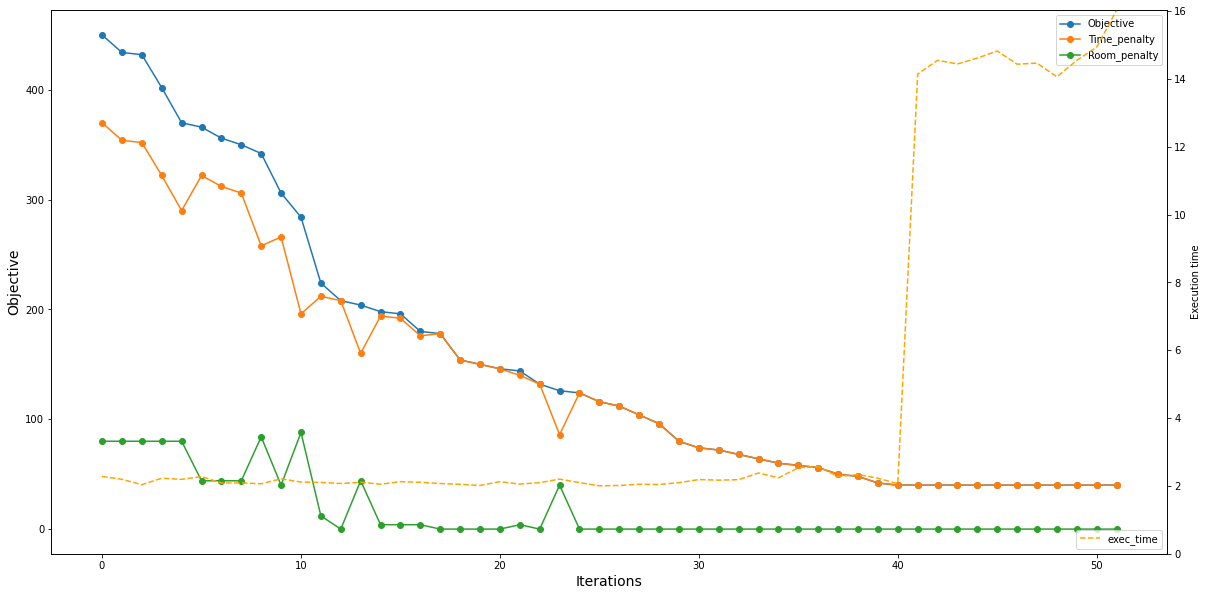

In [77]:
import matplotlib.pyplot as plt
import json

fileObj=open(progress_filename,"r")
content=fileObj.readlines()
obj = json.loads(content[0][:-1])
exec_time = json.loads(content[1])

print('Total runtime: {0:.4f} seconds'.format(sum(exec_time)))
print('Objective value: {0}'.format(obj[-1][-1]))

plt.figure(figsize=(20,10))
ax = plt.gca()
ax2 = ax.twinx()

ax.plot([i for i in range(len(obj))], [val[2] for val in obj], marker='o', label='Objective')
ax.plot([i for i in range(len(obj))], [val[0] for val in obj], marker='o', label='Time_penalty')
ax.plot([i for i in range(len(obj))], [val[1] for val in obj], marker='o', label='Room_penalty')
ax.set_ylabel('Objective', fontsize=14)
ax.set_xlabel('Iterations', fontsize=14)

ax2.plot([i for i in range(len(obj))], [val for val in exec_time], linestyle='dashed', color='orange', label='exec_time')
ax2.set_ylabel('Execution time')
ax2.set_ylim(0, max(exec_time))

ax.legend()
ax2.legend(loc='lower right')
plt.show();